<a href="https://colab.research.google.com/github/rayenayari/news_categorization/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import sklearn
import os
from os import listdir
print(listdir('./'))
from google.colab import drive
drive.mount('/content/gdrive')



['.config', 'sample_data']
Mounted at /content/gdrive


The dataset is initially formatted as a Json list. We need to transform it to a pandas Dataframe

In [ ]:
import matplotlib.pyplot as plt
#import keras
plt.rcParams['figure.figsize'] = (16,10)
df = pd.read_json('./gdrive/MyDrive/Colab Notebooks/News_Category_Dataset_v2.json', lines=True)
df.head(4)


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26


Let's see the columns:

In [ ]:
columns=df.columns
print("Total number of columns {}".format(len(columns)))

Total number of columns 6


For efficiency purposes, we will only use the category and the headline columns. 

In [ ]:
df["headline"]+=" "+df.short_description
df=df[["category","headline"]]

df.head(4)

,category,headline
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...


We need to merge the worldpost and world post.
We merge similar categories to get a more uniform distribution.
For example, business and money become business and Finance

In [ ]:
df=df.copy()
#df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x )
df['category']=df['category'].replace({"HEALTHY LIVING": "WELLNESS",
"QUEER VOICES": "GROUPS VOICES",
"BUSINESS": "BUSINESS & FINANCES",
"PARENTS": "PARENTING",
"BLACK VOICES": "GROUPS VOICES",
"THE WORLDPOST": "WORLD NEWS",
"STYLE": "STYLE & BEAUTY",
"GREEN": "ENVIRONMENT",
"TASTE": "FOOD & DRINK",
"WORLDPOST": "WORLD NEWS",
"SCIENCE": "SCIENCE & TECH",
"TECH": "SCIENCE & TECH",
"MONEY": "BUSINESS & FINANCES",
"ARTS": "ARTS & CULTURE",
"COLLEGE": "EDUCATION",
"LATINO VOICES": "GROUPS VOICES",
"CULTURE & ARTS": "ARTS & CULTURE",
"FIFTY": "MISCELLANEOUS",
"GOOD NEWS": "MISCELLANEOUS"})

In [ ]:
categories=df.groupby("category")
print("Total number of categories: {}".format(categories.ngroups))

Total number of categories: 26


We rename the columns: category-> y and headline-> text

In [ ]:
df=df.rename(columns={"headline":"text","category":'y'})
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True) 
#we print 2 rows
df.sample(2)


,y,text
108674,ARTS & CULTURE,Lorna Simpson Creates Haunting Meditations On ...
24801,PARENTING,"Why I Still Believe in Santa Instantly, every ..."


We need to convert category to id

In [ ]:
# category to id
categories = df.groupby('y').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['y'].apply(lambda x: category_int[x])
category_int

{'ARTS & CULTURE': 0,
 'BUSINESS & FINANCES': 1,
 'COMEDY': 2,
 'CRIME': 3,
 'DIVORCE': 4,
 'EDUCATION': 5,
 'ENTERTAINMENT': 6,
 'ENVIRONMENT': 7,
 'FOOD & DRINK': 8,
 'GROUPS VOICES': 9,
 'HOME & LIVING': 10,
 'IMPACT': 11,
 'MEDIA': 12,
 'MISCELLANEOUS': 13,
 'PARENTING': 14,
 'POLITICS': 15,
 'RELIGION': 16,
 'SCIENCE & TECH': 17,
 'SPORTS': 18,
 'STYLE & BEAUTY': 19,
 'TRAVEL': 20,
 'WEDDINGS': 21,
 'WEIRD NEWS': 22,
 'WELLNESS': 23,
 'WOMEN': 24,
 'WORLD NEWS': 25}

We see the composition of the dataset. This would be helpful to draw conclusions about the accuracy of our model(s).
Clearly, we expect a better accuracy for politics categorization.

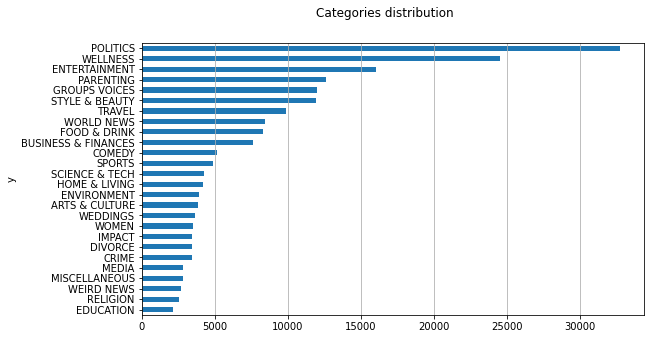

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
fig.suptitle("Categories distribution", fontsize=12)
df["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

### Preprocessing the data:

We need to clean the data:
- We merge categories that are very close
- We remove stop words and we apply lemmatization (used from towardsdatascience)

In [ ]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
import re
nltk.download('wordnet')
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and   characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text
utils_preprocess_text("ray an", flg_stemm=False, flg_lemm=True, lst_stopwords=["ray"])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


'an'

Corpus stop words:

In [ ]:
nltk.download('stopwords')
list_stopwords=nltk.corpus.stopwords.words("english")
list_stopwords[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

We clean the dataset using the function written above:

In [ ]:
df["clean_text"] = df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=list_stopwords))

We compare text with clean text:

In [ ]:
print("Text before cleaning: {}\n".format(df["text"][1]))
print("Text after cleaning: {}\n".format(df["clean_text"][1]))

Text before cleaning: Dan Harmon Talks "Harmontown" and Dungeons & Dragons at SXSW "It was honestly all about pursuing comfort and fleeing pain," he says of his decision to work on his own projects after

Text after cleaning: dan harmon talk harmontown dungeon dragon sxsw honestly pursuing comfort fleeing pain say decision work project



We delete empty and short data:

In [ ]:
df["word_length"]=df.clean_text.apply(lambda x: len(x.split()))
df=df[df.word_length>=5]
df.head(4)

df.sample(2)

,y,text,c2id,clean_text,word_length
15305,POLITICS,HuffPost Rise: What You Need To Know On May 31...,15,huffpost rise need know may 31 welcome huffpos...,17
83843,BUSINESS & FINANCES,"Fed Upgrades The Economy, But Will Be 'Patient...",1,fed upgrade economy patient raising rate,6


Now, we divide the data into train/dev/test split according to 80/10/10

In [ ]:
from sklearn.model_selection import train_test_split
X = df['clean_text']
y = df['c2id']
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(157952,)
(157952,)
(19744,)
(19744,)
(19745,)
(19745,)


(None, None)

All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_size = 12000 # arbitrarily chosen
embed_size = 32 # arbitrarily chosen

# Create and Fit tokenizer
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X_train)

# Tokenize data
X_train_rnn = tok.texts_to_sequences(X_train)
X_test_rnn = tok.texts_to_sequences(X_test)

# Pad data
maxlen = 50
X_train_rnn = pad_sequences(X_train_rnn, maxlen=maxlen)
X_test_rnn = pad_sequences(X_test_rnn, maxlen=maxlen)

### RNN MODEL SUMMARY


In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
model.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(26, activation='softmax')) #softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            384000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           164864    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           164352    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [ ]:
#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
checkpoint_filepath = './gdrive/MyDrive/Colab Notebooks/rnn/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# CHANGE LEARNING RATES 

In [ ]:
#Compile and Fit Model
from sklearn.model_selection import GridSearchCV
model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 

history=model.fit(X_train_rnn, 
          y_train, 
          batch_size=256, 
          validation_data=(X_test_rnn, y_test), 
          epochs=20,callbacks=[model_checkpoint_callback])

Play with learning rate and momentum:

In [ ]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
def create_model(learn_rate=0.01):
	# create model
  model = Sequential()
  model.add(Embedding(vocab_size, embed_size, input_length=maxlen))
  model.add(Bidirectional(LSTM(128, return_sequences=True))) 
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
  model.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
  model.add(Dense(64))
  model.add(Dropout(0.25))
  model.add(Dense(26, activation='softmax'))  
	# Compile model
  optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
  model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer=optimizer, 
              metrics=['accuracy']) 
  return model
  # create model
model = KerasClassifier(build_fn=create_model, epochs=2, batch_size=10, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_rnn, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
score=model.evaluate(X_test_rnn, y_test)

618/618 [==============================] - 13s 22ms/step - loss: 1.2013 - accuracy: 0.6688


In [ ]:
# Tokenize data
X_valid_rnn = tok.texts_to_sequences(X_valid)
X_valid_rnn= pad_sequences(X_valid_rnn, maxlen=maxlen)
val_score=model.evaluate(X_valid_rnn,y_valid)

617/617 [==============================] - 14s 21ms/step - loss: 1.2047 - accuracy: 0.6616


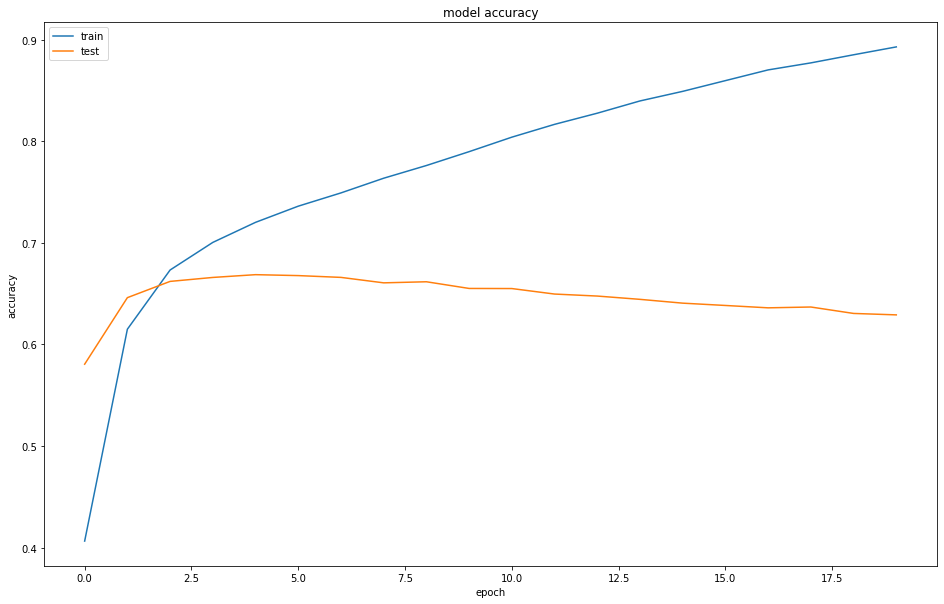

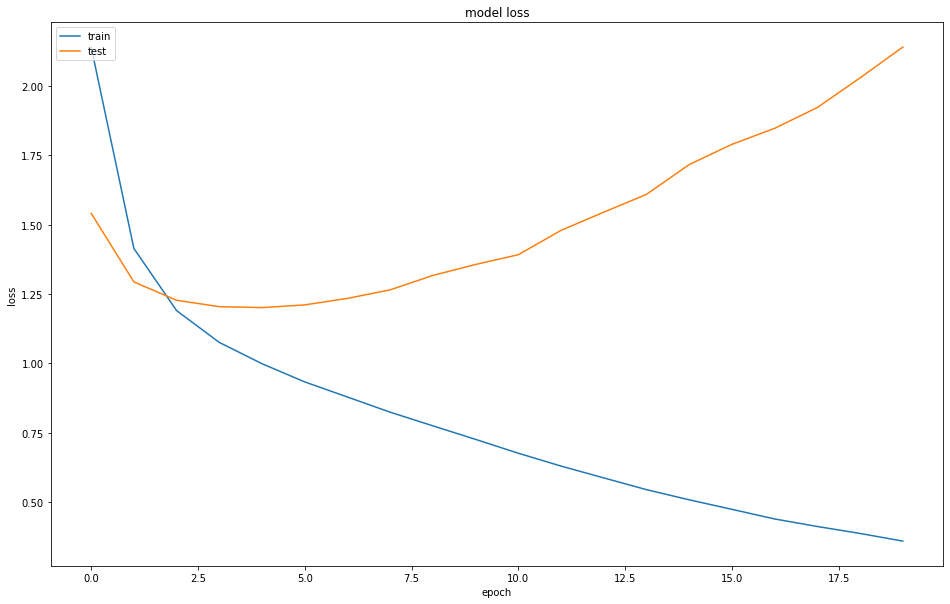

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's do some predictions

In [ ]:
pred = model.predict(X_test_rnn) 
pred = np.argmax(pred, axis = 1) 
print(pred[:5]) 
print(y_test.to_list()[:5])

#mapping the encoded output to actual categories
predicted_category = [int_category[x] for x in pred]
true_category = [int_category[x] for x in y_test]
print(predicted_category[1])

[21 15 16 21  6]
[21, 15, 16, 21, 6]
POLITICS


We build a PD containing the predictions:
We need to reconvert X_test back from sequence to text

In [ ]:
result_df_rnn = pd.DataFrame({'description':tok.sequences_to_texts(X_test_rnn),'true_category':true_category, 'predicted_category':predicted_category})
result_df_rnn.head()

,description,true_category,predicted_category
0,meet sir richard branson human bowling ball,SPORTS,POLITICS
1,hotel destination every urban destination ive ...,TRAVEL,TRAVEL
2,country made environment project finance one g...,ENVIRONMENT,ENVIRONMENT
3,national park service study historic lgbtq sit...,POLITICS,GROUPS VOICES
4,senate favor former executive charged insider ...,POLITICS,POLITICS


In [ ]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df_rnn['true_category'], result_df_rnn['predicted_category'])}")

Accuracy is 0.6201570017726007


We visualize the confusion matrix:

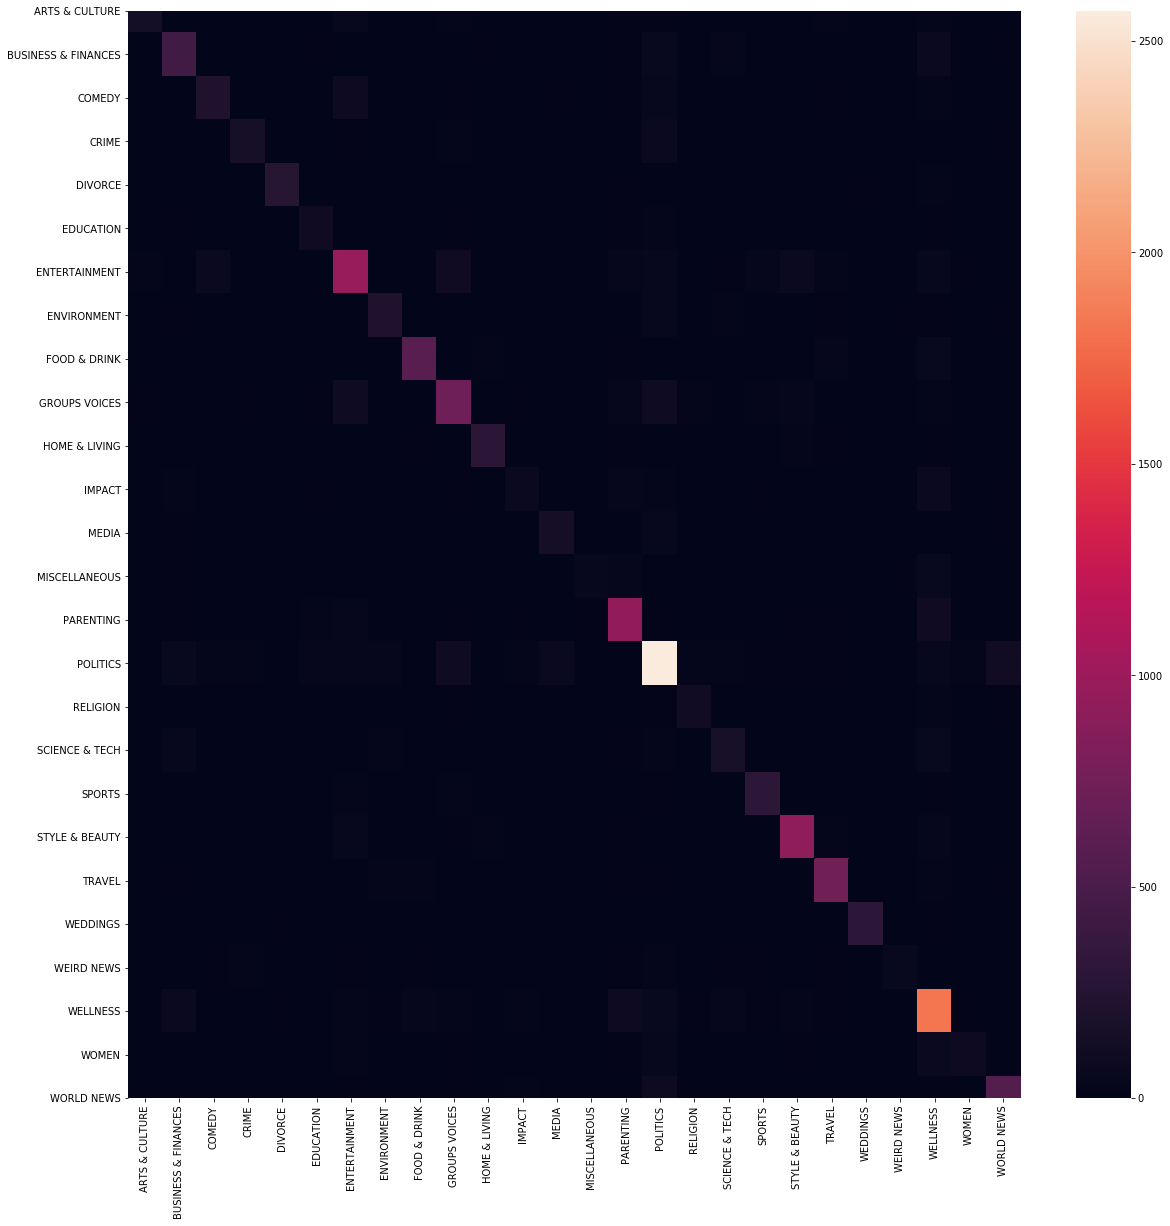

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(category_int))
df_cm = pd.DataFrame(confusion_mat, index = list(category_int),columns = list(category_int))
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(df_cm)

#### Accuracy and Loss:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_pred=np.array(predicted_category),y_true=np.array(true_category))
#result = {'eval_loss': val_loss,
                 # 'eval_accuracy': accuracy,
                  #'loss': loss}
# Save the report into file
output_eval_file = os.path.join('./gdrive/MyDrive/Colab Notebooks/rnn', "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
   # for key in sorted(result.keys()):
     #   print("  %s = %s"%(key, str(result[key])))
      #  writer.write("%s = %s\n" % (key, str(result[key])))
        
    print(report)
    writer.write("\n\n")  
    writer.write(report)

***** Eval results *****
                     precision    recall  f1-score   support

     ARTS & CULTURE       0.51      0.41      0.45       380
BUSINESS & FINANCES       0.57      0.50      0.53       739
             COMEDY       0.60      0.39      0.47       502
              CRIME       0.58      0.60      0.59       327
            DIVORCE       0.81      0.74      0.78       329
          EDUCATION       0.51      0.38      0.44       213
      ENTERTAINMENT       0.63      0.73      0.68      1578
        ENVIRONMENT       0.44      0.43      0.44       382
       FOOD & DRINK       0.78      0.77      0.77       809
      GROUPS VOICES       0.63      0.55      0.59      1179
      HOME & LIVING       0.75      0.71      0.73       421
             IMPACT       0.46      0.20      0.28       346
              MEDIA       0.56      0.39      0.46       270
      MISCELLANEOUS       0.27      0.06      0.09       265
          PARENTING       0.72      0.73      0.72      125

### BERT classification:

We will use the HuggingFace tokenizer for bert to tokenize the given news descriptions.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text as text

In [ ]:
!pip install transformers
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased") #Tokenizer

     |████████████████████████████████| 2.9 MB 13.3 MB/s 
     |████████████████████████████████| 3.3 MB 30.4 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 895 kB 40.2 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

We create the Bert model:

We will use TPU for faster computations.

In [ ]:
try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

Found TPU at: grpc://10.52.121.74:8470


In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1'
tfhub_handle_preprocess ='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(26, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
bert_model = build_classifier_model()

In [ ]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'default': (None, 2 9591041     preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

We must preprocess the clean text before training:
For this, we will use the preprocess model corresponding to the BERT model we have chosen.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's see an example:

In [ ]:
text_test = [X_train[0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2961  5045  2588 10611  3050  3349  2181  5008  3518  2082  5843]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Use a tf optimizer rather than a Keras one for now
bert_model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 
checkpoint_filepath = './gdrive/MyDrive/Colab Notebooks/bert/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history_bert=bert_model.fit(X_train, 
          y_train, 
          batch_size=128, 
          validation_data=(X_test, y_test), 
          epochs=2,callbacks=[model_checkpoint_callback])
bert_model.load_weights(checkpoint_filepath)

Epoch 1/2
1234/1234 [==============================] - 1334s 1s/step - loss: 1.3117 - accuracy: 0.6347 - val_loss: 1.0974 - val_accuracy: 0.6807
Epoch 2/2
1234/1234 [==============================] - 1336s 1s/step - loss: 0.9141 - accuracy: 0.7321 - val_loss: 1.0857 - val_accuracy: 0.6922


#### Accuracy and Loss:

In [ ]:
history_bert.history
acc = history_bert.history['accuracy']
val_acc = history_bert.history['val_accuracy']
loss = history_bert.history['loss']
val_loss = history_bert.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

NameError: ignored

In [ ]:
pred = bert_model.predict(X_test) 
pred = np.argmax(pred, axis = 1) 
predicted_category = [int_category[x] for x in pred]
true_category = [int_category[x] for x in y_test]
from sklearn.metrics import classification_report
report = classification_report(y_pred=np.array(predicted_category),y_true=np.array(true_category))
#result = {'eval_loss': val_loss,
                 # 'eval_accuracy': accuracy,
                  #'loss': loss}
# Save the report into file
output_eval_file = os.path.join('./gdrive/MyDrive/Colab Notebooks/bert', "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
   # for key in sorted(result.keys()):
     #   print("  %s = %s"%(key, str(result[key])))
      #  writer.write("%s = %s\n" % (key, str(result[key])))
        
    print(report)
    writer.write("\n\n")  
    writer.write(report)

### XLNet classification:

In the last few years, Google's Bert and recent transformer-based methods have taken the NLP landscape to a new level.<br>
XLNet is a method developed by CMU. It is a generalised autoregressive pretraining method that outperforms BERT on sentiment analysis. Adding recurrence leads to a deeper understanding of the language context. <br>
Reference: [XLNet Paper](https://arxiv.org/abs/1906.08237)

#### Set Data into training embeddings:

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.6 MB/s 


In [ ]:
print(listdir('./'))

['.config', 'sample_data']


In [ ]:
!pip install transformers
from transformers import (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer)

In [ ]:
vocabulary='./xlnet-base-cased-spiece.model'
tokenizer = XLNetTokenizer(vocab_file=vocabulary,do_lower_case=False)

Set text input embedding:

In [ ]:
max_len  = 50

full_input_ids = []
full_input_masks = []
full_segment_ids = []

SEG_ID_A   = 0
SEG_ID_B   = 1
SEG_ID_CLS = 2
SEG_ID_SEP = 3
SEG_ID_PAD = 4

UNK_ID = tokenizer.encode("<unk>")[0]
CLS_ID = tokenizer.encode("<cls>")[0]
SEP_ID = tokenizer.encode("<sep>")[0]
MASK_ID = tokenizer.encode("<mask>")[0]
EOD_ID = tokenizer.encode("<eod>")[0]

for i,sentence in enumerate(X):
    # Tokenize sentence to token id list
    tokens_a = tokenizer.encode(sentence)
    
    # Trim the len of text
    if(len(tokens_a)>max_len-2):
        tokens_a = tokens_a[:max_len-2]
        
        
    tokens = []
    segment_ids = []
    
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(SEG_ID_A)
        
    # Add <sep> token 
    tokens.append(SEP_ID)
    segment_ids.append(SEG_ID_A)
    
    
    # Add <cls> token
    tokens.append(CLS_ID)
    segment_ids.append(SEG_ID_CLS)
    
    input_ids = tokens
    
    # The mask has 0 for real tokens and 1 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [0] * len(input_ids)

    # Zero-pad up to the sequence length at fornt
    if len(input_ids) < max_len:
        delta_len = max_len - len(input_ids)
        input_ids = [0] * delta_len + input_ids
        input_mask = [1] * delta_len + input_mask
        segment_ids = [SEG_ID_PAD] * delta_len + segment_ids

    assert len(input_ids) == max_len
    assert len(input_mask) == max_len
    assert len(segment_ids) == max_len
    
    full_input_ids.append(input_ids)
    full_input_masks.append(input_mask)
    full_segment_ids.append(segment_ids)
    
    if 3 > i:
        print("No.:%d"%(i))
        print("sentence: %s"%(sentence))
        print("input_ids:%s"%(input_ids))
        print("attention_masks:%s"%(input_mask))
        print("segment_ids:%s"%(segment_ids))
        print("\n")

Split Data:

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(full_input_ids, y.to_list(),full_input_masks,full_segment_ids, 
                                                            random_state=4, test_size=0.3)

In [ ]:
import transformers
xlnet= transformers.AutoTokenizer.from_pretrained("xlnet-base-cased") #Tokenizer

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [ ]:
import torch
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
tr_segs = torch.tensor(tr_segs)
val_segs = torch.tensor(val_segs)


Put data into data loader:

In [ ]:
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
#  batch num
batch_num = 128
# Set token embedding, attention embedding, segment embedding
train_data = TensorDataset(tr_inputs, tr_masks,tr_segs, tr_tags)
train_sampler = RandomSampler(train_data)
# Drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks,val_segs, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_adress="../content/gdrive/MyDrive/Colab Notebooks"
xLNet_model = XLNetForSequenceClassification.from_pretrained(model_adress,num_labels=26)

Some weights of the model checkpoint at ../content/gdrive/MyDrive/Colab Notebooks were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at ../content/gdrive/MyDrive/Colab Notebooks and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-

In [ ]:
# Set epoch and grad max num
import math
epochs = 5
max_grad_norm = 1.0
# Calculate train optimization num
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
# Set model to GPU,if you are using GPU machine
xLNet_model.to(device);

In [ ]:
# We need to finetune the model
FULL_FINETUNING = True

In [ ]:
if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(xLNet_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(xLNet_model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [ ]:
xLNet_model.train()

In [ ]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))
for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs,b_labels = batch
        
        # forward pass
        outputs = xLNet_model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        loss, logits = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=xLNet_model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

***** Running training *****
  Num examples = 138208
  Batch size = 128
  Num steps = 5400


Epoch:  20%|██        | 1/5 [43:56<2:55:44, 2636.12s/it]

Train loss: 1.2937184181668562


Epoch:  40%|████      | 2/5 [1:27:59<2:12:01, 2640.48s/it]

Train loss: 0.9222620390044859


Epoch:  60%|██████    | 3/5 [2:12:04<1:28:05, 2642.56s/it]

Train loss: 0.7646562112659299


Epoch:  80%|████████  | 4/5 [2:56:07<44:02, 2642.62s/it]  

Train loss: 0.6330918940103529


Epoch: 100%|██████████| 5/5 [3:40:02<00:00, 2640.53s/it]

Train loss: 0.5172429136013521


In [ ]:
xlnet_out_address ="../content/gdrive/MyDrive/Colab Notebooks/out"

In [ ]:
if not os.path.exists(xlnet_out_address):
        os.makedirs(xlnet_out_address)

In [ ]:
# Save a trained model, configuration and tokenizer
model_to_save = xLNetmodel.module if hasattr(xLNet_model, 'module') else xLNet_model  # Only save the model it-self

In [ ]:
# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(xlnet_out_address, "pytorch_model.bin")
output_config_file = os.path.join(xlnet_out_address, "config.json")

In [ ]:
# Save model into file
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(xlnet_out_address)

('../content/gdrive/MyDrive/Colab Notebooks/out/spiece.model',)

Load the New model:

In [ ]:
model = XLNetForSequenceClassification.from_pretrained(xlnet_out_address,num_labels=26)

In [ ]:
# Set model to GPU
model.to(device);

Evaluate model:

In [ ]:
# Evalue loop
model.eval();

In [ ]:
# Set acc funtion
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

In [ ]:
from sklearn.metrics import classification_report
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

y_true = []
y_predict = []
print("***** Running evaluation *****")
print("  Num examples ={}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))
for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch
    
    with torch.no_grad():
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        tmp_eval_loss, logits = outputs[:2]
    
    # Get textclassification predict result
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
#     print(tmp_eval_accuracy)
#     print(np.argmax(logits, axis=1))
#     print(label_ids)
    
    # Save predict and real label reuslt for analyze
    for predict in np.argmax(logits, axis=1):
        y_predict.append(predict)
        
    for real_result in label_ids.tolist():
        y_true.append(real_result)

    
    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
   
    nb_eval_steps += 1
    
    
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(val_inputs)
loss = tr_loss/nb_tr_steps 
result = {'eval_loss': eval_loss,
                  'eval_accuracy': eval_accuracy,
                  'loss': loss}
report = classification_report(y_pred=np.array(y_predict),y_true=np.array(y_true))

# Save the report into file
output_eval_file = os.path.join(xlnet_out_address, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
        print("  %s = %s"%(key, str(result[key])))
        writer.write("%s = %s\n" % (key, str(result[key])))
        
    print(report)
    writer.write("\n\n")  
    writer.write(report)

***** Running evaluation *****
  Num examples =59233
  Batch size = 128
***** Eval results *****
  eval_accuracy = 0.7277193456350345
  eval_loss = 1.00088896208139
  loss = 0.5172429136013521
              precision    recall  f1-score   support

           0       0.70      0.48      0.57      1141
           1       0.65      0.58      0.61      2213
           2       0.59      0.52      0.55      1520
           3       0.63      0.66      0.65      1007
           4       0.87      0.76      0.81      1084
           5       0.66      0.43      0.52       635
           6       0.70      0.77      0.73      4674
           7       0.58      0.63      0.61      1135
           8       0.82      0.83      0.82      2471
           9       0.65      0.66      0.66      3538
          10       0.80      0.80      0.80      1304
          11       0.44      0.44      0.44      1020
          12       0.56      0.58      0.57       833
          13       0.42      0.38      0.40       